<div class="alert alert-info" role="alert">
    <h1 style="color:black; font-size:250%; text-align:center" >Análisis de Ventas. Distribuidor Equipo de Montaña<a class='tocSkip'a> </h1>
</div>

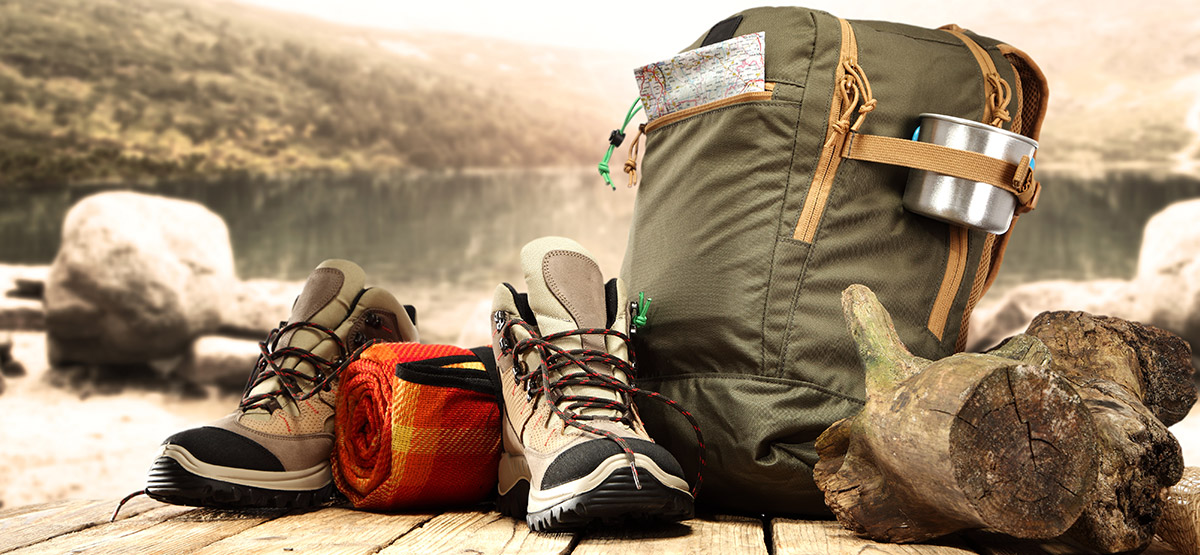

# Introducción <a class="tocSkip">

Esta es la tercer parte del proyecto iniciado tiempo atrás en donde el objetivo principal es el de practicar y demostrar habilidad en el manejo del lenguaje **SQL**. Se continua con el mismo ejemplo que es el de una empresa ficticia denominada *Extreme Sports House*, distribuidor líder en equipo de montaña, senderismo y aventura.

<div class=text-justify>
Se seguirá trabajando con MySQL que es una de las herramientas más populares en los entornos empresariales debido a que es open source. La segunda herramienta será Python con el IDE de Jupiter notebook, para poder mostrar los resultados de las consultas y, sobretodo, poder publicar este cuaderno en la web.
<div/>

Se crearán algunas consultas para diseñar un sistema de recomendación sencillo basado en frecuencias.

# set up <a class="tocSkip">

In [1]:
import pandas as pd
import pymysql
import pymysql.cursors
import credenciales as cds

pd.options.display.float_format = '{:.2f}'.format

# Diagrama ER <a class="tocSkip">

Con el propósito de conocer distintas tablas y sus relaciones, a continuación, se muestra la imagen del modelo de la base de datos:

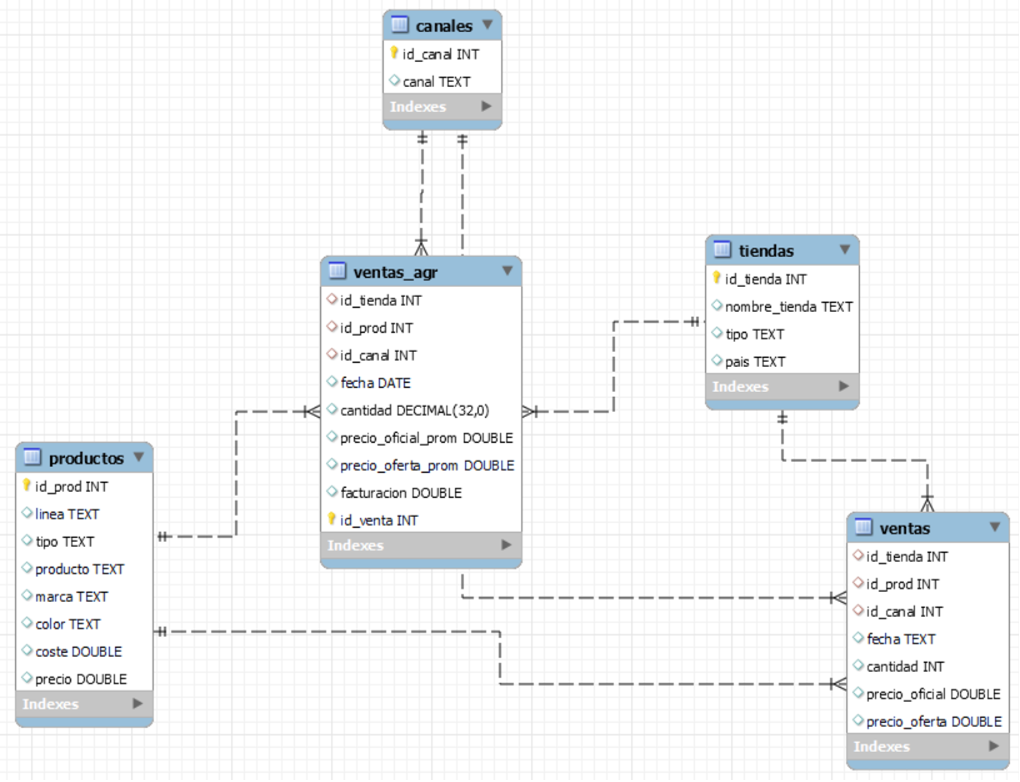

# Conexion a la base de datos <a class="tocSkip">

Antes que nada, hay que establecer la conexion con MySQL. Estaré usando mi equipo como servidor, por lo que, el host será local:

In [2]:
conexion = pymysql.connect(host = "localhost", 
                           user = cds.user, 
                           passwd = cds.passwd, 
                           database = "caso")

cursor = conexion.cursor()

Ya que se estableció la conexión a la base de datos con la que se trabajará, ahora se mostrarán las tablas que contiene  dicha base de datos:

In [3]:
tablas = "SHOW TABLES;"

In [4]:
cursor.execute(tablas)
filas = cursor.fetchall()

print("Tablas de la base 'caso':\n")

for fila in filas:
   print(fila)

conexion.close()

Tablas de la base 'caso':

('canales',)
('productos',)
('recomendador',)
('tiendas',)
('v_matriz_segmentacion',)
('v_ventas_agr_pedido',)
('ventas',)
('ventas_agr',)


<div class=text-justify>
Para trabajar más comodamente se crea una función, en python, para la ejecución de las consultas, ya que de esa manera, solamente se tendrá que trabajar en la consulta sin la necesidad de tener que repetir las credenciales para establecer la conexion. Además, al final la salida de las consultas será un dataframe de pandas para facilitar la visualización del resultado, ya que la salida del query es una lista de tuplas, lo cual no es tan amigable de leer.
</div>

In [5]:
def query(DB, consulta):
    
    con = pymysql.connect(
            host = 'localhost',
            user = cds.user,
            password = cds.passwd,
            db = DB,
            cursorclass = pymysql.cursors.DictCursor)

    try:

        with con.cursor() as cur:

            cur.execute(consulta)

            rows = cur.fetchall()
            desc = cur.description

            df_mysql = pd.DataFrame.from_dict(rows, orient = 'columns')

    finally:

        con.close()

    return df_mysql

La primer consulta es para conocer la tabla principal *ventas_agr:*

In [6]:
consulta = "SELECT * FROM ventas_agr;"

In [7]:
query('caso', consulta)

,id_tienda,id_prod,id_canal,fecha,cantidad,precio_oficial_prom,precio_oferta_prom,facturacion,id_venta
0,1201,109110,4,2015-01-12,648,76.86,71.48,46319.04,1
1,1201,112110,4,2015-01-12,799,10.64,10.21,8157.79,2
2,1201,115110,4,2015-01-12,755,10.71,10.28,7761.40,3
3,1205,70240,3,2015-01-12,70,122.70,114.11,7987.70,4
4,1205,71110,3,2015-01-12,28,95.62,92.75,2597.00,5
...,...,...,...,...,...,...,...,...,...
134683,1258,52110,5,2018-07-09,1011,38.00,36.48,36881.28,134684
134684,1258,53110,5,2018-07-09,476,39.99,25.99,12371.24,134685
134685,1258,54110,5,2018-07-09,476,52.99,52.99,25223.24,134686
134686,1258,55110,5,2018-07-09,476,8.00,8.00,3808.00,134687


Todo funciona bien, por lo que, de aquí en adelante se harán consultas más complejas.

# Sistema de recomendación <a class='tocSkip'>

# Diseñar un sistema de recomendación item-item que localice aquellos productos que son comprados frecuentemente en el mismo pedido. Además, que se le pueda recomendar a cada tienda (cliente) según su propio historial de productos comprados

La estratégia a seguir será:

1. Crear una tabla que será la tabla maestra de las recomendaciones item-item.
2. Hacer la consulta que genere las recomendaciones para cada tienda o cliente.
3. Eliminar, de la tabla maestra, los productos que se ya han sido comprados por un mismo cliente.

In [8]:
consulta = "create table sistema_recomendador \
            select v1.id_prod as antecedente, v2.id_prod as consecuente, count(v1.id_pedido) as frecuencia \
            from v_ventas_agr_pedido as v1 \
                inner join v_ventas_agr_pedido as v2 \
                 on v1.id_pedido = v2.id_pedido \
                    and v1.id_prod != v2.id_prod \
                    and v1.id_prod < v2.id_prod \
            group by v1.id_prod, v2.id_prod;"

In [9]:
query('caso', consulta)

""


In [10]:
consulta = "select * from sistema_recomendador;"

In [11]:
query('caso', consulta)

,antecedente,consecuente,frecuencia
0,109110,112110,245
1,109110,115110,233
2,109110,110110,332
3,109110,114110,267
4,112110,115110,270
...,...,...,...
19618,11110,46110,2
19619,11110,47110,2
19620,11110,59110,2
19621,11110,48110,1


# Crear una consulta que genere las recomendaciones para cada cliente en concreto y que sea capaz de eliminar los productos ya comprados por ese cliente

Para finalizar con estos ejercicios se seguirán estos pasos:

1. Crear una primer tabla temporal para hacer una consulta que muestre el id de producto y el id de tienda de una tienda en particular.
2. Crear una segunda tabla temporal para poder agrupar la frecuencia de cada producto comprado por otros clientes.
3. Eliminar del resultado de esa segunda tabla aquellos productos que habian sido comprados previamente por la tienda que se está analizando.

In [12]:
consulta = "with input_cliente as ( \
                    select distinct id_prod, id_tienda \
                    from ventas_agr \
                    where id_tienda = '1201'), \
                productos_recomendados as ( \
                    select consecuente, sum(frecuencia) as frecuencia \
                    from input_cliente as c \
                        left join \
                         sistema_recomendador as r \
                        on c.id_prod = r.antecedente \
                    group by consecuente \
                    order by frecuencia desc) \
            select consecuente as recomendado, frecuencia \
            from productos_recomendados as r \
                left join \
                 input_cliente as c \
                on r.consecuente = c.id_prod \
                where id_prod is null;"

In [13]:
query('caso', consulta)

,recomendado,frecuencia
0,148120,8849
1,152110,8769
2,143110,6315
3,132120,5804
4,154150,4366
...,...,...
153,98110,11
154,8110,9
155,76110,8
156,6110,6
